In [ ]:
# import libraries

from tifffile import *
from wfield import *
from os.path import join as pjoin
import os
import numpy as np
import matplotlib.pyplot as plt
from joblib import dump, load

In [ ]:
# set save folder

localdisk = "base_path"
dat_path = "img_path"
ccf_path = "ccf_path"
template_path =  f"{dat_path}/template_dir"
print(dat_path)
print(localdisk)
fs = 20 # per channel
time = 40
ex = 10  # the number of sessions

D:/Python_TK_3/datas/regist_images/250926_GCaMP/250926_04/dat
D:/Python_TK_3/datas/regist_images/250926_GCaMP


In [ ]:
# import your folders for every cycle

datfolders = [pjoin(dat_path,i) for i in os.listdir(dat_path) if os.path.isdir(pjoin(dat_path,i))]
datfolders = sorted(datfolders)
for i in datfolders:
    print(i)

D:/Python_TK_3/datas/regist_images/250926_GCaMP/250926_04/dat\ex0
D:/Python_TK_3/datas/regist_images/250926_GCaMP/250926_04/dat\ex1
D:/Python_TK_3/datas/regist_images/250926_GCaMP/250926_04/dat\ex2
D:/Python_TK_3/datas/regist_images/250926_GCaMP/250926_04/dat\ex3
D:/Python_TK_3/datas/regist_images/250926_GCaMP/250926_04/dat\ex4
D:/Python_TK_3/datas/regist_images/250926_GCaMP/250926_04/dat\ex5
D:/Python_TK_3/datas/regist_images/250926_GCaMP/250926_04/dat\ex6
D:/Python_TK_3/datas/regist_images/250926_GCaMP/250926_04/dat\ex7
D:/Python_TK_3/datas/regist_images/250926_GCaMP/250926_04/dat\ex8
D:/Python_TK_3/datas/regist_images/250926_GCaMP/250926_04/dat\ex9


In [ ]:
# import transform algorithm

memory_mapped_dats = []
transform_mats = []

for session_folder in tqdm(datfolders):
    tiffiles = sorted(glob(pjoin(session_folder, "*.tif")))
    for file in tiffiles:
        memory_mapped_dats.append(memmap(file))
        affine_path = file.rstrip(".tif") + "_affine_transform.joblib"
        M = load(affine_path)
        transform_mats.append(M)


100%|██████████| 10/10 [00:00<00:00, 70.49it/s]


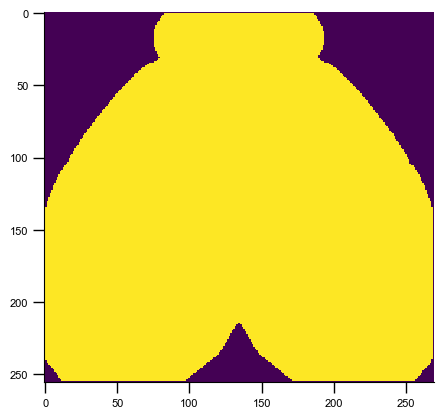

In [ ]:
# import brain mask

lmarks = load_allen_landmarks(filename=pjoin(template_path, "analysis_landmarks.json"))
ccf_regist_matrix = lmarks["transform"]
brain_mask = np.load(pjoin(template_path, "brain_mask.npy"))
plt.imshow(brain_mask)

In [ ]:
# make folder for saving all cycles .tif

all_path = pjoin(dat_path, "all")
os.mkdir(all_path)

output_path = os.path.join(all_path, f"{analysis_folder}_{ex}ex.tif")

In [ ]:
# save the .tif to the folder

# append=True is essential
with TiffWriter(output_path, append=True, bigtiff=True) as tif_writer:
    for j, M in tqdm(zip(memory_mapped_dats, transform_mats)):
        composite_transform = ccf_regist_matrix + M
        for image in j:
            transformed_image = brain_mask*im_apply_transform(image, composite_transform).astype('uint16')
            transformed_image = np.nan_to_num(transformed_image, nan=0).astype('uint16')
            tif_writer.write(transformed_image, contiguous=True)

10it [00:39,  3.95s/it]


In [ ]:
# import the tif

dat = memmap(output_path)
print(dat.shape)

(16000, 256, 270)


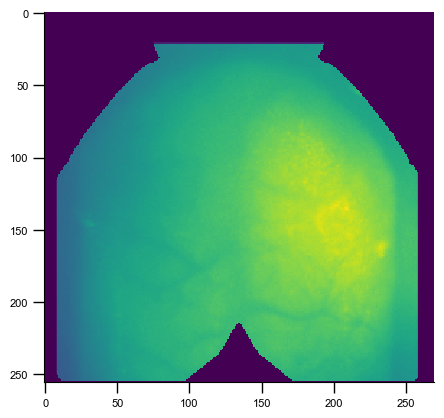

In [ ]:
plt.imshow(dat[0])

In [ ]:
# save with .npy

output_path_np = os.path.join(all_path, f"{analysis_folder}_{ex}ex.npy")

np.save(output_path_np, dat)

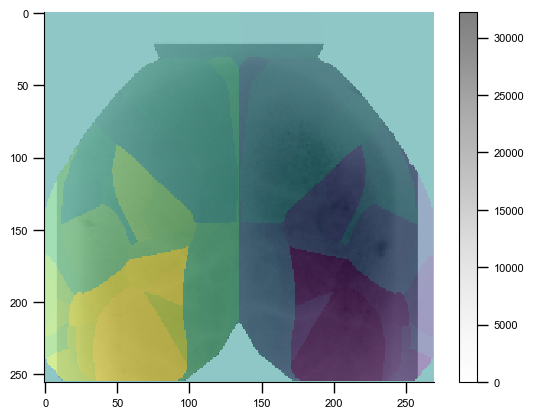

In [ ]:
# show atlas and image after registration

atlas = np.load(pjoin(template_path, "atlas.npy"))

# visualize
plt.imshow(atlas, interpolation='none')  # show atlas
plt.imshow(dat[0], cmap='Grays', alpha=0.5, interpolation='none')  # show cortex

plt.colorbar()
plt.show()

In [ ]:
# make function to visualize activities of ROIs you want to see in 1 cycle

import numpy as np
import matplotlib.pyplot as plt

def roi_setting(img_array):

    time_steps, height, width = img_array.shape


    roi1 = np.zeros((height, width), dtype=bool)
    roi1[200:230, 180:210] = 1

    rois = [roi1]

    roi_means = []
    for roi in rois:
        mean_values = np.array([np.mean(frame[roi]) for frame in img_array])
        roi_means.append(mean_values)

    roi_means = np.array(roi_means)

    print("average time course in ROIs:", roi_means.shape)  # (ROIs, frames)


    plt.figure(figsize=(6, 6))
    plt.imshow(img_array[0], cmap='gray', interpolation='nearest')

    for idx, roi in enumerate(rois):
        #plt.contour(roi, colors=[f'C{idx}'], linewidths=1.5, label=f'ROI {idx + 1}')
        plt.contour(roi, colors='red', linewidths=3, label=f'ROI {idx + 1}')

    plt.show()

    return roi_means

In [ ]:
# make function to visualize activities of a ROI you want to see in your whole experient

import numpy as np
import matplotlib.pyplot as plt

frames = 800

def roi_calc(img_array):

    time_steps, height, width = img_array.shape
    roi = np.zeros((height, width), dtype=bool)
    roi[200:230, 180:210] = 1  # (y, x)
    mean_values = np.array([np.mean(frame[roi]) for frame in img_array])

    return mean_values

In [ ]:
# set time frames

# start time
start_value = 0.0

# increase per frames
increment = 0.05

# frames
count = 800

t = [start_value + i * increment for i in range(count)]

In [ ]:
# show your ROIs and fluorescence with blue excitation in your 1 experiment

ex = 1
frames = 800

roi_means = roi_setting(dat[ex*2*frames:(ex+1)*2*frames][::2])
for i in range(roi_means.shape[0]):
    plt.plot(t[:frames], roi_means[i][:frames])
    #plt.axvspan(20, 30, color='red', alpha=0.3)
    plt.show()

    fig, ax = plt.subplots()
    ax.plot(t[:frames], roi_means[i][:frames], color='blue')
    #plt.axvspan(20, 30, color='red', alpha=0.3)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.show()

In [ ]:
# show your ROIs and fluorescence with violet excitation in your 1 experiment

roi_means = roi_setting(dat[ex*2*frames:(ex+1)*2*frames][1::2])
for i in range(roi_means.shape[0]):
    plt.plot(t[:frames], roi_means[i][:frames])
    #plt.axvspan(20, 30, color='red', alpha=0.3)
    plt.show()

    fig, ax = plt.subplots()
    ax.plot(t[:frames], roi_means[i][:frames], color='darkviolet')
    #plt.axvspan(20, 30, color='red', alpha=0.3)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.show()

In [ ]:
# show your ROIs and ΔF/F with blue and violet excitation in your 1 experiment

roi_means = roi_setting(dat[ex*2*frames:(ex+1)*2*frames][::2])
roi_means2 = roi_setting(dat[ex*2*frames:(ex+1)*2*frames][1::2])
for i in range(roi_means.shape[0]):
    norm_roi_470 = (roi_means[i][:frames]-np.mean(roi_means[i][:frames])) / np.mean(roi_means[i][:frames])
    plt.plot(t[:frames], norm_roi_470, color='blue')
    norm_roi_405 = (roi_means2[i][:frames]-np.mean(roi_means2[i][:frames])) / np.mean(roi_means2[i][:frames])
    plt.plot(t[:frames], norm_roi_405, color='darkviolet')
    #plt.axvspan(20, 30, color='red', alpha=0.3)
    plt.show()

    fig, ax = plt.subplots()
    ax.plot(t[:frames], norm_roi_470, color='blue')
    ax.plot(t[:frames], norm_roi_405, color='darkviolet')
    #plt.axvspan(20, 30, color='red', alpha=0.3)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.show()

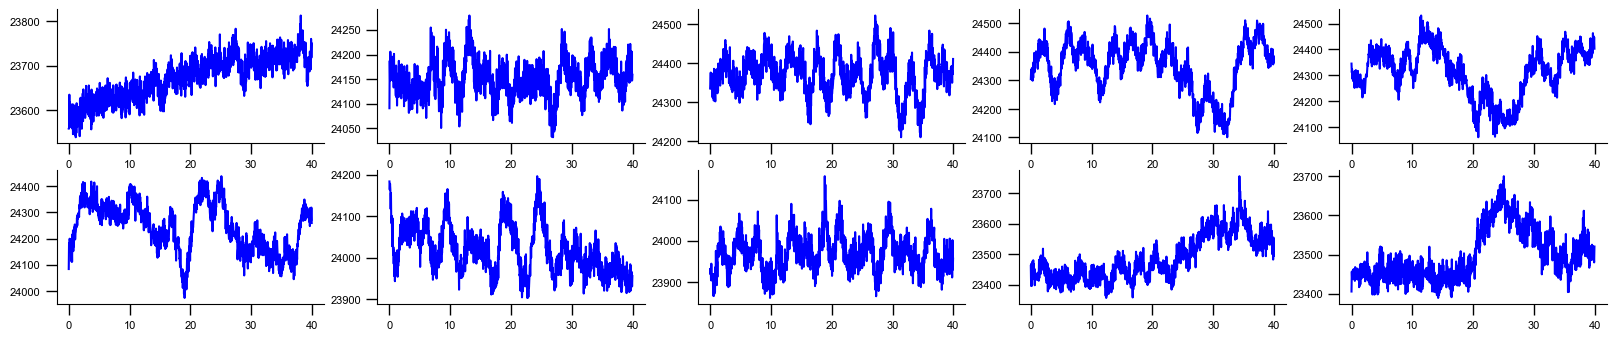

In [ ]:
# show fluorescence of your ROI with blue excitation in your whole experiment

plt.figure(figsize=(20, 8))  # width 20 inch, height 8 inch

for ex in range(int(dat.shape[0]/(frames*2))):
    mean_values = roi_calc(dat[ex*frames*2:(ex+1)*frames*2][::2])
    plt.subplot(4, 5, ex+1)
    plt.plot(t[:frames], mean_values, color='blue')
    #plt.axvspan(20, 30, color='red', alpha=0.3)
    #plt.ylim(25500, 27500)

plt.show()

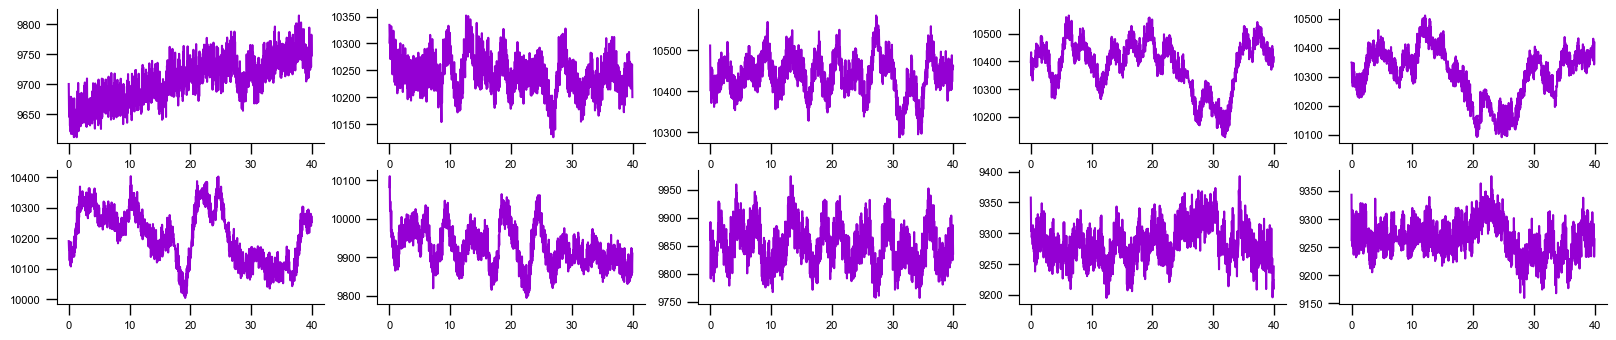

In [ ]:
# show fluorescence of your ROI for violet excitation in your whole experiment

plt.figure(figsize=(20, 8))  # width 20 inch, height 8 inch

for ex in range(int(dat.shape[0]/(frames*2))):
    mean_values = roi_calc(dat[ex*frames*2:(ex+1)*frames*2][1::2])
    plt.subplot(4, 5, ex+1)
    plt.plot(t[:frames], mean_values, color='darkviolet')
    #plt.axvspan(20, 30, color='red', alpha=0.3)
    #plt.ylim(14100, 17000)

plt.show()

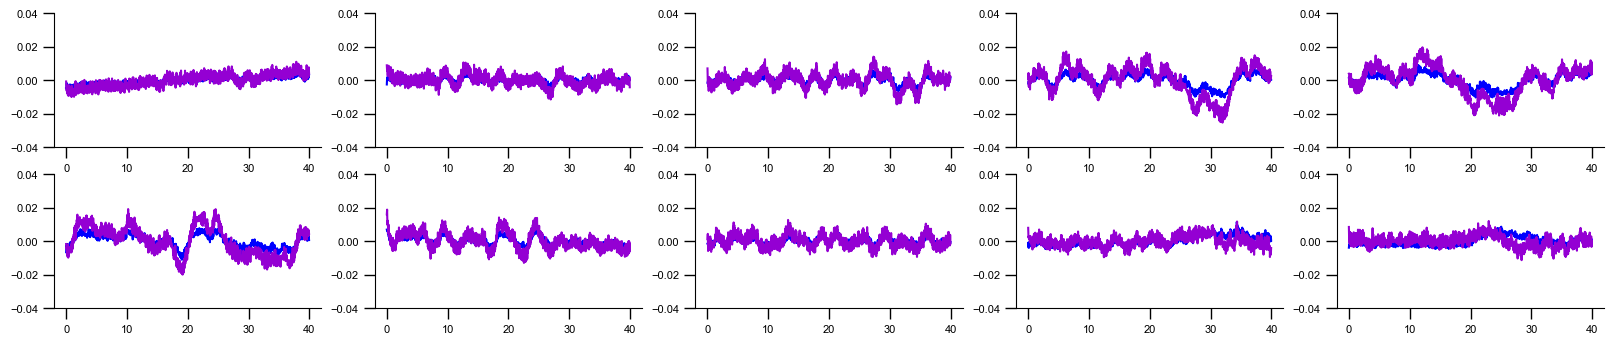

In [ ]:
# show ΔF/F of your ROI for blue and violet excitation in your whole experiment

plt.figure(figsize=(20, 8))  # width 20 inch, height 8 inch

for ex in range(int(dat.shape[0]/(frames*2))):
    mean_values = roi_calc(dat[ex*frames*2:(ex+1)*frames*2][::2])
    norm_470 = (mean_values-np.mean(mean_values)) / np.mean(mean_values)

    mean_values2 = roi_calc(dat[ex*frames*2:(ex+1)*frames*2][1::2])
    norm_405 = (mean_values2-np.mean(mean_values2)) / np.mean(mean_values2)

    plt.subplot(4, 5, ex+1)
    plt.plot(t[:frames], norm_470, color='blue')
    plt.plot(t[:frames], norm_405, color='darkviolet')
    #plt.axvspan(20, 30, color='red', alpha=0.3)
    plt.ylim(-0.04, 0.04)

plt.show()